In [3]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'1AOI4HD8fSAqer-eTj2dzOeeMQ0un-z3O' in parents and trashed=false"}).GetList()

ModuleNotFoundError: No module named 'google.colab'

In [2]:
%matplotlib inline
import random
import time
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
from pylab import rcParams
import os
import json

/Users/cassiocamilo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
MODEL_PATH = '../data/model_artif/'
SAMPLES_PATHS = ['data/placas_br__placas_br/']

In [5]:
EPOCH = 20

In [6]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Import data

In [21]:
def LoadImage(fname):
#    qtde = fname.split("/")
#    query = "title = '"+qtde[len(qtde)-1]+"'"
#    file_list = drive.ListFile({'q': query}).GetList()

#    train_downloaded = drive.CreateFile({'id': file_list[0]['id']})
#    train_downloaded.GetContentFile(qtde[len(qtde)-1])

    return io.imread(fname, as_grey=True)[:,:] / 255.

In [7]:
def LoadAnnotation(fname):
    with open(fname) as data_file:    
        data = json.load(data_file)
#    qtde = fname.split("/")
    
#    query = "title = '"+qtde[len(qtde)-1]+"'"
#    file_list = drive.ListFile({'q': query}).GetList()

#    train_downloaded = drive.CreateFile({'id': file_list[0]['id']})
    #train_downloaded.GetContentFile('dados.csv')

#    content = train_downloaded.GetContentString()

#    data = json.loads(content)  

    left = data["objects"][0]["points"]["exterior"][0][0]
    top = data["objects"][0]["points"]["exterior"][0][1]
    right = data["objects"][0]["points"]["exterior"][1][0]
    bottom = data["objects"][0]["points"]["exterior"][1][1]
    
    return [left, top, right, bottom]

In [14]:
def ReadDirFiles(dname):
    paths = []
    for file in os.listdir(os.path.join(dname, "img")):
        bname = os.path.basename(file).split(".")[0]
        
        img_name = os.path.join(dname, "img", file)
        ann_name = os.path.join(dname, "ann", bname + ".json")
        paths.append((img_name, ann_name))
    return paths

In [15]:
def ReadPaths(paths):
    all_paths = []
    for path in paths:
        temp_paths = ReadDirFiles(path)
        all_paths.extend(temp_paths)
    return all_paths

In [16]:
def get_tags(fname):
  
#    qtde = fname.split("/")
    
#    query = "title = '"+qtde[len(qtde)-1]+"'"
#    file_list = drive.ListFile({'q': query}).GetList()

#    train_downloaded = drive.CreateFile({'id': file_list[0]['id']})
    #train_downloaded.GetContentFile('dados.csv')

#    content = train_downloaded.GetContentString()

#    data = json.loads(content)  
  
    with open(fname) as data_file:
        data = json.load(data_file)
    tags = data["tags"]
    return tags

In [17]:
def train_test_split(paths, train_tag="train", test_tag="test"):
    train_paths = []
    test_paths = []
    for path in paths:
        img_path, ann_path = path
        tags = get_tags(ann_path)
        if train_tag in tags:
            train_paths.append(path)
        if test_tag in tags:
            test_paths.append(path)
    return train_paths, test_paths

In [18]:
all_paths = ReadPaths(SAMPLES_PATHS)
tr_paths, te_paths = train_test_split(all_paths)

print(len(tr_paths))
print(len(te_paths))

25
7


In [19]:
def LoadData(paths):
    xs = []
    ys = []
    for ex_paths in paths:
        img_path = ex_paths[0]
        ann_path = ex_paths[1]
        xs.append(LoadImage(img_path))
        ys.append(LoadAnnotation(ann_path))
    
    return np.array(xs), np.array(ys)

In [22]:
X_train, Y_train = LoadData(tr_paths)
X_test, Y_test = LoadData(te_paths)

print("check shapes:")
print("X_train - ", X_train.shape)
print("Y_train - ", Y_train.shape)
print("X_test - ", X_test.shape)
print("Y_test - ", Y_test.shape)

check shapes:
X_train -  (25, 600, 752)
Y_train -  (25, 4)
X_test -  (7, 600, 752)
Y_test -  (7, 4)


### Show sample images

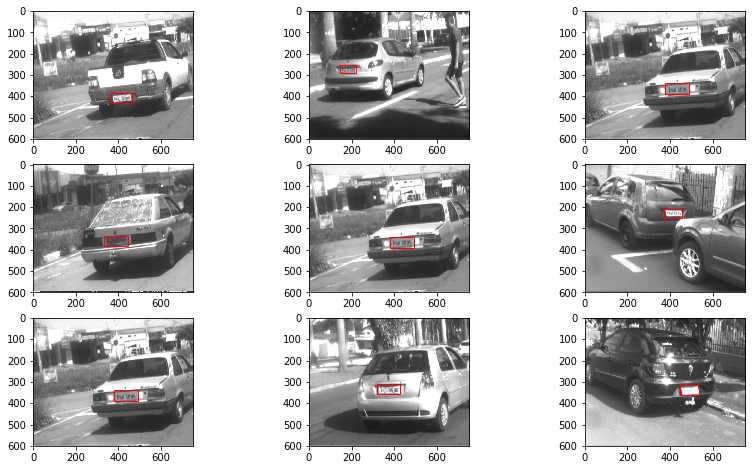

In [23]:
def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_images(images, labels):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    for i in range(min(9, images.shape[0])):
        fig.add_subplot(3, 3, i+1)
        show_image(images[i], labels[i])
    plt.show()    
    
xs = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]                   
plot_images(X_train[xs], Y_train[xs])  

## Batch iterator

In [24]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

## Build Tensorflow neural net

In [25]:
def mse(expected, predicted):
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

In [26]:
def weight_variable(name, shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.get_variable(name, initializer=initial)

def bias_variable(name, shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name, initializer=initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    

In [27]:
PIXEL_COUNT = X_train.shape[1] * X_train.shape[2]
LABEL_COUNT = Y_train.shape[1]
# Create placeholders for image data and expected point positions

class Model(object):
    xxx = 0
    
    
# Build neural network
def build_model():
    x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])
    y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

    x_image = tf.reshape(x_placeholder, [-1, 600, 752, 1])
    # Convolution Layer 1
    W_conv1 = weight_variable("w1", [3, 3, 1, 32])
    b_conv1 = bias_variable("b1", [32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    # Convolution Layer 2
    W_conv2 = weight_variable("w2", [2, 2, 32, 64])
    b_conv2 = bias_variable("b2", [64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # Convolution Layer 3
    W_conv3 = weight_variable("w3", [2, 2, 64, 128])
    b_conv3 = bias_variable("b3", [128])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    # Dense layer 1
    h_pool3_flat = tf.reshape(h_pool3, [-1, 75*94*128])
    W_fc1 = weight_variable("w4", [75*94*128, 500])
    b_fc1 = bias_variable("b4", [500])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)   
    # Dense layer 2
    W_fc2 = weight_variable("w5", [500, 500])
    b_fc2 = bias_variable("b5", [500])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)  
    # Output layer
    W_out = weight_variable("w6", [500, LABEL_COUNT])
    b_out = bias_variable("b6", [LABEL_COUNT])
    
    output = tf.matmul(h_fc2, W_out) + b_out
    
    model = Model()
    model.x_placeholder = x_placeholder
    model.y_placeholder = y_placeholder
    model.output = output
    
    return model

### Train

In [28]:
X2_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
Y2_train = Y_train / (64.0, 32.0, 64.0, 32.0) - 1.0

X2_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
Y2_test = Y_test / (64.0, 32.0, 64.0, 32.0) - 1

dataset = Dataset(X2_train, Y2_train)

In [ ]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    
    model = build_model()
    loss = mse(model.y_placeholder, model.output)
    
    saver = tf.train.Saver()
    start_time = time.time()
    best_score = 1

    train_step = tf.train.AdamOptimizer().minimize(loss)

    session = tf.InteractiveSession()
    session.run(tf.global_variables_initializer())
    #saver.restore(session, os.path.join(MODEL_PATH, "model"))

    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={model.x_placeholder: batch_x, model.y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch:
            last_epoch = dataset.epoch_completed()
            score_test = loss.eval(feed_dict={model.x_placeholder: X2_test, model.y_placeholder: Y2_test})
            if score_test < best_score:
                best_score = score_test
                saver.save(session, os.path.join(MODEL_PATH, "model"))
            if dataset.epoch_completed() % 1 == 0:
                epm = 60 * dataset.epoch_completed() / (time.time()-start_time)
                print('Epoch: %d, Score: %f, Epoch per minute: %f' % (dataset.epoch_completed(), score_test, epm))
    print('Finished in %f seconds.' % (time.time()-start_time)) 
    
    session.close()

Epoch: 0, Score: 131575.687500, Epoch per minute: 0.000000
Epoch: 1, Score: 2290.479980, Epoch per minute: 0.161440
Epoch: 2, Score: 21828.816406, Epoch per minute: 0.227533


### Show test set predictions

In [1]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    ids = [random.randint(0, X2_test.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_test[ids]})
    plot_images(X_test[ids], (predictions+1) * (64, 32, 64, 32))
    session.close()

NameError: ignored

### Show train set predictions

INFO:tensorflow:Restoring parameters from ../data/model_artif/model


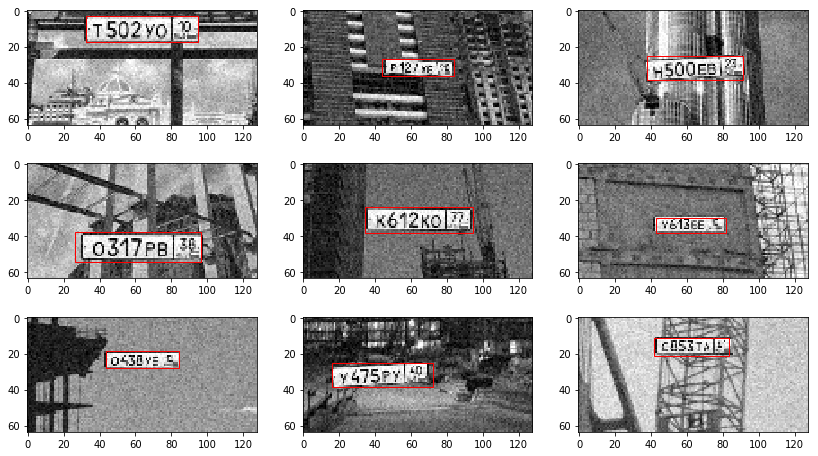

In [0]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    
    ids = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_train[ids]})
    plot_images(X_train[ids], (predictions+1) * (64, 32, 64, 32))

    session.close()